# Simple implementation of network propagation from Vanunu et. al.

### Author: Brin Rosenthal (sbrosenthal@ucsd.edu)
### March 24, 2016

Note: data and code for this notebook may be found in the 'data' and 'source' directories 

In [1]:
# import some useful packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
import pandas as pd
import random

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

import sys
#sys.path.append('/Users/brin/Google Drive/UCSD/genome_interpreter_docs/barabasi_disease_distances/barabasi_incomplete_interactome/source/')
sys.path.append('source/')
import separation
import plotting_results
import network_prop

import imp
imp.reload(separation)
imp.reload(plotting_results)
imp.reload(network_prop)


% matplotlib inline

### Load the interactome from Barabasi paper

Interactome downloaded from supplemental materials of http://science.sciencemag.org/content/347/6224/1257601 (Menche, Jörg, et al. "Uncovering disease-disease relationships through the incomplete interactome." Science 347.6224 (2015): 1257601.)

<img src="screenshots/barabasi_abstract.png" width="600" height="600">

- We need a reliable background interactome in order to correctly calculate localization and co-localization properties of node sets
- We have a few choices in this decision, three of which are outlined below:

<img src="screenshots/which_interactome.png" width="800" height="800">

In [2]:
# load the interactome network (use their default network)
Gint = separation.read_network('data/DataS1_interactome.tsv')
# remove self links
separation.remove_self_links(Gint)
# Get rid of nodes with no edges
nodes_degree = Gint.degree()
nodes_0 = [n for n in nodes_degree.keys() if nodes_degree[n]==0]
Gint.remove_nodes_from(nodes_0)


> done loading network:
> network contains 13460 nodes and 141296 links


### Load a focal gene set

Gene lists should follow the format shown here for kidney_diseases.txt and epilepsy_genes.txt, and should be in the entrez ID format

In [3]:
genes_KID = separation.read_gene_list('kidney_diseases.txt')
genes_EPI = separation.read_gene_list('epilepsy_genes.txt')


# set disease name and focal genes here
dname = 'kidney'
genes_focal = genes_KID


> done reading genes:
> 110 genes found in kidney_diseases.txt

> done reading genes:
> 32 genes found in epilepsy_genes.txt


# Network propagation from seed nodes

### First calculate the degree-corrected version of adjacency matrix

Network propagation simulation follows methods in http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000641 (Vanunu, Oron, et al. "Associating genes and protein complexes with disease via network propagation." PLoS Comput Biol 6.1 (2010): e1000641.)

<img src="screenshots/vanunu_abstract.png">

### Calculate the degree- normalized adjacency matrix, using network_prop.normalized_adj_matrix function

In [4]:
Wprime= network_prop.normalized_adj_matrix(Gint)


### Propagate heat from seed disease, examine the community structure of hottest nodes

In [5]:
seed_nodes = list(np.intersect1d(list(genes_focal),Gint.nodes()))
alpha=.5  # this parameter controls how fast the heat dissipates
Fnew = network_prop.network_propagation(Gint,Wprime,seed_nodes,alpha=alpha,num_its=20)

## Plot the hot subnetwork

1. Create subgraphs from interactome containing only disease genes
2. Sort the heat vector (Fnew), and select the top_N hottest genes to plot

In [6]:
Fsort = Fnew.sort(ascending=False)
top_N = 200
F_top_N = Fnew.head(top_N)
gneigh_top_N = list(F_top_N.index)
G_neigh_N = Gint.subgraph(gneigh_top_N)
# pull out some useful subgraphs for use in plotting functions
# find genes which are neighbors of seed genes
genes_in_graph = list(np.intersect1d(Gint.nodes(),list(genes_focal)))
G_focal=G_neigh_N.subgraph(list(genes_in_graph))


/root/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


Set the node positions using nx.spring_layout.  Parameter k controls default spacing between nodes (lower k brings the nodes closer together, higher k pushes them apart) 

In [7]:
pos = nx.spring_layout(G_neigh_N,k=.03)  # set the node positions

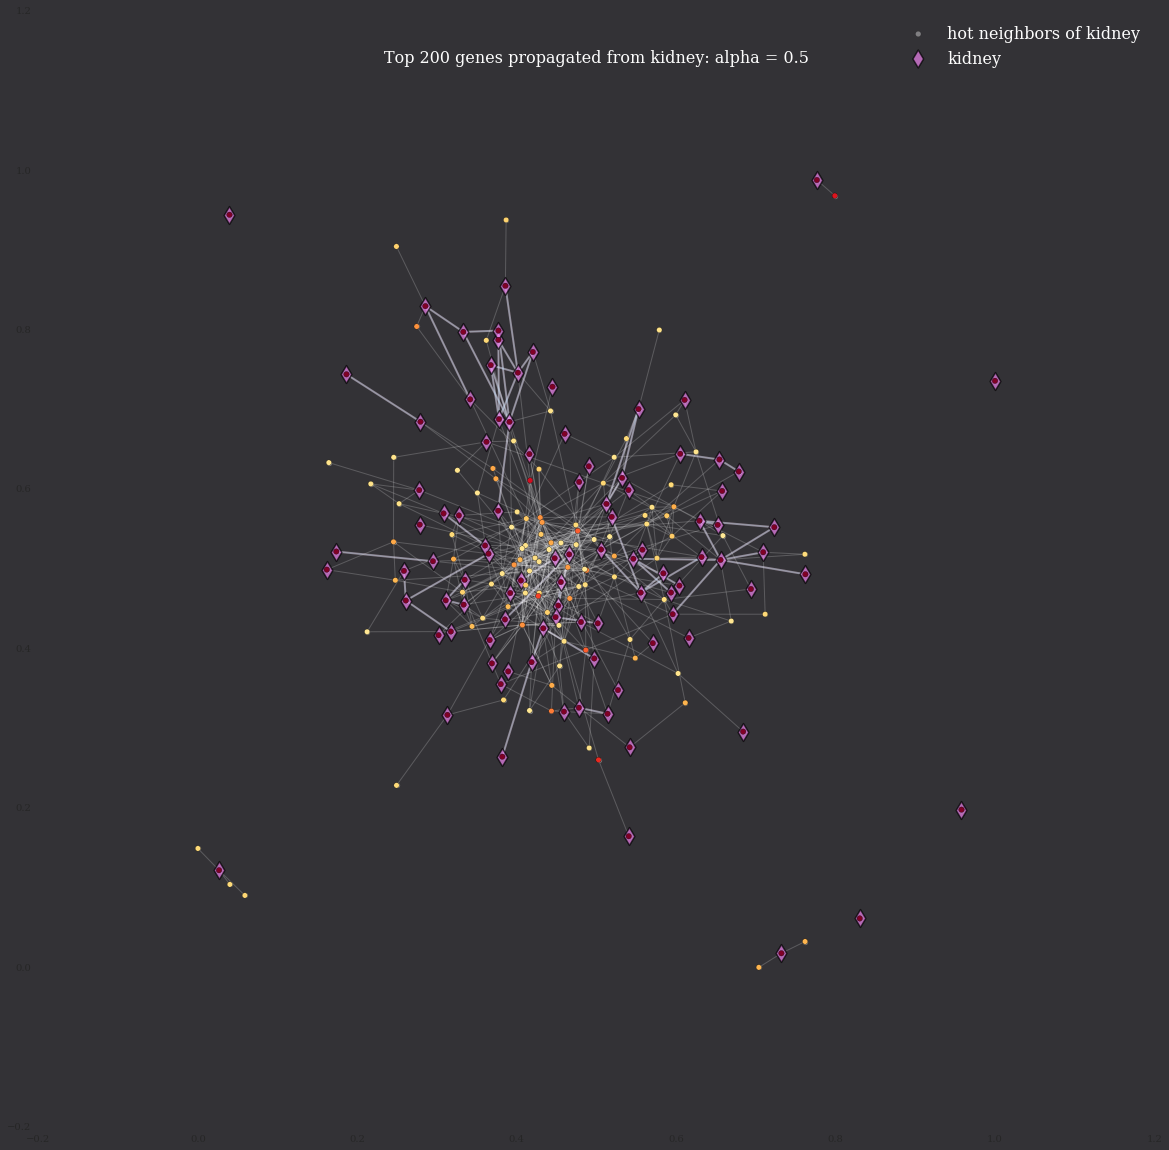

In [8]:
plotting_results.plot_network_2_diseases(G_neigh_N,pos,G_focal,d1name=dname,saveflag=False)
nx.draw_networkx_nodes(G_neigh_N,pos=pos,node_color=Fnew[G_neigh_N.nodes()],cmap='YlOrRd',node_size=30,
                      vmin=0,vmax=max(Fnew)/3)
nx.draw_networkx_edges(G_neigh_N,pos=pos,edge_color='white',alpha=.2)
plt.title('Top '+str(top_N)+' genes propagated from '+dname+': alpha = ' + str(alpha),color='white',fontsize=16,y=.95)
plt.savefig('heat_prop_network.png',dpi=200)  # save the figure here

## What are the top N genes?  Print out gene symbols 

- These are the genes which are likely to be related to input gene set

(Convert from entrez ID to gene symbol using MyGene.info)

In [9]:
import mygene
mg = mygene.MyGeneInfo()

In [10]:
# print out the names of the top N genes (that don't include the seed set)
focal_group = list(F_top_N.index)
focal_group = np.setdiff1d(focal_group,list(genes_focal))
top_heat_focal = F_top_N[focal_group]
focal_temp = mg.getgenes(focal_group)
focal_entrez_names = [str(x['entrezgene']) for x in focal_temp if 'symbol' in x.keys()]
focal_gene_names = [str(x['symbol']) for x in focal_temp if 'symbol' in x.keys()]
top_heat_df = pd.DataFrame({'gene_symbol':focal_gene_names,'heat':top_heat_focal[focal_entrez_names]})
top_heat_df = top_heat_df.sort('heat',ascending=False)
# print the top 25 related genes, along with their heat values
top_heat_df.head(25)

querying 1-103...done.


/root/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,gene_symbol,heat
5174,PDZK1,0.002999
5362,PLXNA2,0.002867
5213,PFKM,0.002646
5566,PRKACA,0.002435
2885,GRB2,0.002215
27347,STK39,0.002207
9943,OXSR1,0.001985
9641,IKBKE,0.001940
5567,PRKACB,0.001820
5568,PRKACG,0.001814
